Note: all written responses are in <span style="color:DodgerBlue">DodgerBlue</span>.

## Assignment 1: Implementation of Stochastic Optimization Methods (SGD + Variance Reduction)##

This jupyter notebook is Assignment 1 for the course "EN.553.662: Optimization for Data Science".

In this assignment we will focus on the practical implementation of Stochastic Gradient Methods for solving popular optimization problems. All algorithms and their convergence guarantees presented in the class. 

You have to complete 2 main tasks each of them being equal to 50 points of the total 100 points of this assignment. 

The Assignemnt is equivalent to 15% of the final grade. 

PLEASE SUBMIT THE ipynb file to CANVAS. Penalty for not doing so (submitting a pdf instead): 10 points.

PLEASE INCLUDE COMMENTS IN YOUR CODE explaining your steps. 

The missing parts of the code which require your input (update in terms of code) are denoted with ............

## 1. Loss functions, gradients and step-sizes

Throughout this assignment we will focus on two classes of of finite-sum problems of the form: 
$$
 \min_{x\in R^d} \left[ f(x) = \frac{1}{n} \sum_{i=1}^n f_i( \langle A_i , x \rangle, b_i) \right],
$$
where $A_i$ is a vector (or matrix) of features and $b_i$ is an observation/label. This as we mention in the lectures corresponds to dataset $$ D= \{ (A_i, b_i ), i = 1,2,\dots , n\},$$ which we assume that has been cleaned (all pairs ($A_i, b_i )$ have the same size and shape). 

The problems that we are interested in are 

##### Ridge regression: 
$$ \min_x f(x)= \frac{1}{n} \sum_{i=1}^n \frac{1}{2} \left( A_i^\top x - b_i \right)^2 + \frac{\lambda}{2} \|x\|^2$$

#####  $\ell_2$ regularized logistic regression:
$$ \min_x f(x)= \frac{1}{n} \sum_{i=1}^n \log \left(1+e^{-b_i \langle A_i , x \rangle} \right) +\frac{\lambda}{2} \|x\|^2$$


Note that both of the above problems can be writen as an optimization problem of the form: 
$$
\frac 1n \sum_{i=1}^n f_i(x)
$$

where for ridge regression: 
$$
f_i(x) = \frac{1}{2} \left( A_i^\top x - b_i \right)^2 + \frac{\lambda}{2} \|x\|^2,
$$
and for logistic regression: 
$$
f_i(x)=\log \left(1+e^{-b_i \langle A_i , x \rangle} \right) +\frac{\lambda}{2} \|x\|^2.
$$

## 2. Generate Data 

Let us first explain what would be the datasets for the problems under study. 
That is explain how the matrix A and vector b (labels) of the main problems are selected. 

In particular we will run the methods for solving both synthetic (Gaussian noise) and real data from LIBSVM datasets (https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/). The synthetic data will be constructed in each individial task. For the real data we will use the following package: 

pip install libsvmdata

from libsvmdata import fetch_libsvm

X,y = fetch_libsvm(“madelon’)

The names of the dataset used in the assignments of our course are "abalone", "w3a", "a1a", "madelon", "gisette", "a9a". To use them in each experiment you will simply need to call the above function and save the matrix X and vector of labels y. 

In [1]:
# 2.6s
import numpy as np
import matplotlib.pyplot as plt
from libsvmdata import fetch_libsvm

In [2]:
# 1.2s

# Synthetic data
np.random.seed(42)

n_ridge_synth = 1000; d_ridge_synth = 400
n_logit_synth = 2000; d_logit_synth = 100

A_ridge_synth = np.random.randn(n_ridge_synth, d_ridge_synth) 
A_logit_synth = np.random.randn(n_logit_synth, d_logit_synth)

b_ridge_synth = np.random.randn(n_ridge_synth)
b_logit_synth = np.random.choice(a=[-1, 1], size=n_logit_synth, replace=True, p=[0.5, 0.5])

# Real data
A_ridge_real, b_ridge_real = fetch_libsvm("abalone")
A_logit_real, b_logit_real = fetch_libsvm("a1a")
A_logit_real = A_logit_real.toarray()

n_ridge_real, d_ridge_real = A_ridge_real.shape
n_logit_real, d_logit_real = A_logit_real.shape

# Regularization parameter
lamb_ridge_synth = 1.0 / n_ridge_synth
lamb_ridge_real = 1.0 / n_ridge_real
lamb_logit_synth = 1.0 / n_logit_synth
lamb_logit_real = 1.0 / n_logit_real

# Obtain mu & L
mu_ridge_synth = min(np.linalg.eigvals(A_ridge_synth.T @ A_ridge_synth)) / n_ridge_synth + lamb_ridge_synth
mu_ridge_real = min(np.linalg.eigvals(A_ridge_real.T @ A_ridge_real)) / n_ridge_real + lamb_ridge_real
mu_logit_synth = lamb_logit_synth
mu_logit_real = lamb_logit_real 

##  3. Tasks

Having presented the optimization problems of interest and the generation of data. Let us move on to the main tasks of this assignment.

### Task 1: Evaluation of SGD (on synthetic and real data) 

Let us start by stating the theorem as presented in the class: 

Assume $f$ is $\mu$-quasi-strongly convex and that $(f,D)\sim ES(\cal L)$.
Choose   $\gamma_k=\gamma \in (0,  \frac{1}{2\cal L}]$ for all $k$. Then iterates of SGD satisfy: 
\begin{equation}
\mathbb{E} \| x^k - x^* \|^2 \leq \left( 1 - \gamma \mu \right)^k \| x^0 - x^* \|^2 + \frac{2 \gamma \sigma^2}{\mu}. 
\end{equation}

Having this theorem in mind let us now implement some variants of SGD. 

For all plots in this task, to evaluate SGD use the relative error measure  $\dfrac{\|x^k - x^* \|^2}{\|x^0 - x^* \|^2}$ and plot its value as the algorithm progress. For all implementations, select the starting point $x^0$ to be the vector of all zeros. Please run each method until a pre-specified maximum number of epochs that you will select in order for the theoretical result to be illustrated. In this task since we only evaluate single-element sampling SGD for the horizontal axis you can use either the number of epochs or the number of iterations. 

For both problems, ridge regression and logistic regression, $\mathbf{A} \in \mathbb{R}^{n \times d}, b \in \mathbb{R}^n$ are the given data and $\lambda > 0$ is the regularization parameter. 
We generated synthetic data in both problems by sampling the rows of matrix $\mathbf{A}$ ($\mathbf{A}[i, :]$)  from the standard Gaussian distribution $\mathcal{N}(0, 1)$. Furthermore 
for ridge regression we sampled the entries of $b$ from the standard Gaussian distribution while in the case of logistic regression $b \in \{-1, 1\}^n$ where $\mathbb{P}(b_i=1) = \mathbb{P}(b_i=-1) = \dfrac{1}{2}$.
The regularization parameter is selected to be equal to $\lambda=1/n$. 

For synthetic datasets please use $n=1000, d=400$ for the ridge regression problem and $n=2000, d=100$ for the logistic regression problem. For the experiments on real data we will use LIBSVM datasets. In particular select the "abalone" dataset for the ridge regression problem and the "a1a" for the logistic regression problem. 

$\textbf{1.1.}$ (30 points) Design constant step-size SGD with uniform-single elements sampling for solving the least square regression and $\ell_2$-logistic regression problem. 

<span style="color:DodgerBlue"> 

I first implemented functions to compute the gradient both for a specific $f_i$ and for $f$ for each of the two regression problems based on the hints in Lecture 13. 

</span>

In [3]:
# 0.0s

def grad_ridge_fi(Ai, bi, xk, lamb):
    """Computes the gradient of fi at xk for regularized ridge regression."""
    return (np.dot(Ai, xk) - bi) * Ai + lamb * xk

def grad_ridge_f(A, b, xk, lamb):
    """Computes the gradient of f at xk for regularized ridge regression."""
    return A.T @ (A @ xk - b) / A.shape[0] + lamb * xk #(-A.T @ b + A.T @ A @ xk) / A.shape[0] + lamb * xk

def grad_logit_fi(Ai, bi, xk, lamb):
    """Computes the gradient of fi at xk for regularized logistic regression."""
    exp_term = np.exp(- bi * np.dot(Ai, xk))
    return (-bi * exp_term) / (1 + exp_term) * Ai + lamb * xk

def grad_logit_f(A, b, xk, lamb):
    """Computes the gradient of f at xk for regularized logistic regression."""
    exp_term = np.exp(-b * np.dot(A, xk))
    gradient = A * ((-b * exp_term) / (1 + exp_term))[:, np.newaxis]
    grad = gradient + lamb * xk
    return grad.mean(axis=0)

<span style="color:DodgerBlue"> 

Next, I implemented deterministic gradient descent to approximate $x^*$.  

</span>

In [4]:
# 0.0s

def GD(x0, A, b, lamb, step, grad, n_iter = 500, progress = False):
    import tqdm
    x = x0 
    for _ in tqdm.tqdm(range(n_iter), disable=not progress):
        x = x - step * grad(A, b, x, lamb)
    return x

<span style="color:DodgerBlue"> 

Then, I implemented a helper function to help with step-size switching. 

</span>

In [5]:
# 0.0s

def get_switch_iteration(L_cal, mu):
    """Computes the iteration at which the switching occurs."""
    return 4 * np.ceil(L_cal / mu)
    
def get_switch_step_size(L_cal, mu, k):
    """Obtains step size (if we do use the switching scheme)."""
    if k <= get_switch_iteration(L_cal, mu):
        return 1.0 / (2 * L_cal)
    else:
        return (2 * k + 1) / (k + 1)**2 / mu

<span style="color:DodgerBlue"> 

Finally, I implemented a general SGD function that can handle both uniform and importance sampling, constant and switching step size.

</span>

In [6]:
# 0.0s

# SGD with single-element sampling
def SGD(x0, xmin, 
        grad, A, b, lamb, # The data
        step=None, # Step size (if not provided, then assume switching scheme)
        switch=False, L_cal=None, mu=None, # Should be provided if using switching scheme
        pi_importance_vec=None, # Importance sampling or not (and what distribution)
        n_iter=500, trials=10, progress=False):
    """Main stochastic gradient descent function, tracks relative error."""
    from tqdm import tqdm

    relative_error_vec = np.zeros(n_iter) # Placeholder for relative errors
    n = A.shape[0] # Number of samples

    # Iterate over the trial
    for _ in tqdm(range(trials), disable=not progress, desc="trials", leave=True, position=0):  
        x = x0
        relative_error_vec_t = np.zeros(n_iter)

        # Iterate through the iterations
        for k in tqdm(range(n_iter), disable=not progress, desc="iterations", leave=False, position=1): 
            if switch:
                assert L_cal is not None
                assert mu is not None
                step = get_switch_step_size(L_cal, mu, k)

            # Sample a single element 
            if pi_importance_vec is None: # Uniform single-element sampling
                i = np.random.choice(n)
            else: # Importance sampling (partially biased sampling, Slide 64, Lectures 4-6)
                i = np.random.choice(n, p=pi_importance_vec)
            
            # Compute gradient using the sampled observation indexed by i, use it to update xk
            x = x - step * grad(A[i,], b[i], x, lamb)

            # Compute relative error and store it 
            relative_error = np.square(np.linalg.norm(x-xmin) / np.linalg.norm(x0-xmin))
            relative_error_vec_t[k] = relative_error
            
        relative_error_vec += relative_error_vec_t 

    return relative_error_vec / trials # Return average relative error over the runs

$\textbf{1.1.1}$ (6 points) What are the values of the step-size $\gamma=\dfrac{1}{2\cal L}$ in this scenario for the two problems? How the value of  $\cal L$ is related to values $L$ and $L_{max}$ for the case of single-element uniform sampling?

<span style="color:DodgerBlue"> 

Back in Lectures 4-6, a property of expected smoothness is $L \leq \mathcal{L} \leq L_{max}$. 

For single-element sampling, $\mathcal{L} = \dfrac{1}{n} \max_{i \in [n]} \dfrac{L_i}{p_i}$.  

For uniform single-element sampling, $\forall i \in [n], p_i = \dfrac{1}{n} \Rightarrow \mathcal{L} = L_{max}$. 

Also, based on the hints in Lecture 13, for ridge regression, $L_i = ||A_i||^2 + \lambda$; for logistic regression, $L_i = \dfrac{1}{4} ||A_i||^2 + \lambda$. 

</span>

In [7]:
# 0.0s

def get_Li_ridge(A, lamb):
    """Computes Li for each fi in ridge regression."""
    return np.square(np.linalg.norm(A, axis=1)) + lamb

def get_Li_logit(A, lamb):
    """Computes Li for each fi in regularized logistic regression."""
    return 0.25 * np.square(np.linalg.norm(A, axis=1)) + lamb

def get_L_cal(A, lamb, get_Li, p_vec=None):
    """Computes L_cal."""
    if not p_vec:
        n = A.shape[0]
        p_vec = np.repeat(1.0/n, n)
    Li_ridge = get_Li(A, lamb)
    return (Li_ridge / p_vec).max() / n

In [8]:
# 0.0s

# Computing step sizes
Lcal_ridge_synth = get_L_cal(A_ridge_synth, lamb_ridge_synth, get_Li_ridge)
Lcal_ridge_real = get_L_cal(A_ridge_real, lamb_ridge_real, get_Li_ridge)
Lcal_logit_synth = get_L_cal(A_logit_synth, lamb_logit_synth, get_Li_logit)
Lcal_logit_real = get_L_cal(A_logit_real, lamb_logit_real, get_Li_logit)

gamma_ridge_synth = 0.5 / Lcal_ridge_synth
gamma_ridge_real = 0.5 / Lcal_ridge_real
gamma_logit_synth = 0.5 / Lcal_logit_synth
gamma_logit_real = 0.5 / Lcal_logit_real

print(f"For ridge regression, the step size is {gamma_ridge_synth} for synthetic data, {gamma_ridge_real} for real data.")
print(f"For logistic regression, the step size is {gamma_logit_synth} for synthetic data, {gamma_logit_real} for real data.")

For ridge regression, the step size is 0.00102435965740406 for synthetic data, 0.03268276725859848 for real data.
For logistic regression, the step size is 0.013253721254748314 for synthetic data, 0.14283171665035152 for real data.


$\textbf{1.1.2}$ (12 points) Plot how the trajectory of SGD looks like for the theoretical step-size $\gamma=\dfrac{1}{2\cal L}$ for the two problems of ridge regression and logistic regresion in the synthetic regime (1 plot for each problem). How the plot is connected to the theoretical result?  

In [9]:
# 36.3s

# Estimating xmin using GD (ridge regression, synthetic data)
x0_ridge_synth = np.zeros(d_ridge_synth); 
xmin_ridge_synth = GD(x0=x0_ridge_synth, A=A_ridge_synth, b=b_ridge_synth, lamb=lamb_ridge_synth, 
                      step=gamma_ridge_synth, grad=grad_ridge_f, n_iter=200000, progress=True)

100%|██████████| 200000/200000 [00:40<00:00, 4944.75it/s]


Text(0.5, 1.0, 'Trajectory of SGD with constant stepsize = 1/(2Lmax) for synthetic data of ridge regression')

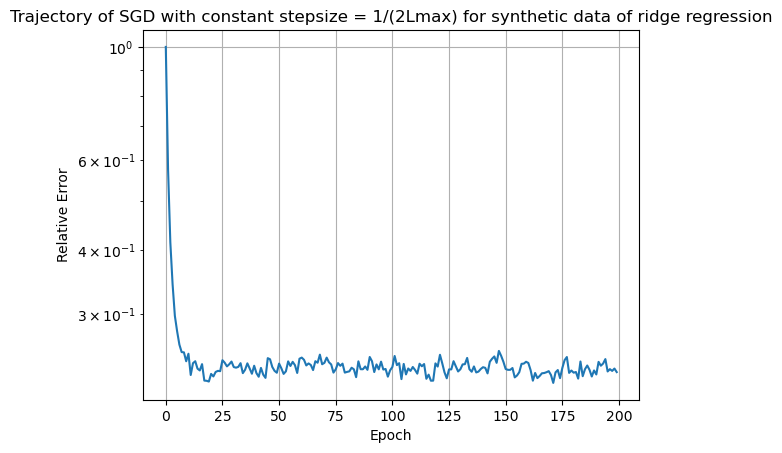

In [10]:
# 20.5s

# SGD with ridge regression (synthetic data)
err_ridge_synth = SGD(x0=x0_ridge_synth, xmin=xmin_ridge_synth, 
                      grad=grad_ridge_fi, A=A_ridge_synth, b=b_ridge_synth, 
                      lamb=lamb_ridge_synth, step=gamma_ridge_synth, 
                      n_iter=200*n_ridge_synth, trials=10, progress=False)

# Plot the Relative Error
plt.plot(np.arange(len(err_ridge_synth[::n_ridge_synth])), err_ridge_synth[::n_ridge_synth])
plt.yscale('log')
plt.grid(True)
plt.ylabel("Relative Error")
plt.xlabel("Epoch")
plt.title('Trajectory of SGD with constant stepsize = 1/(2Lmax) for synthetic data of ridge regression')

In [33]:
# 1m 36.5s

# Estimating xmin using GD (logistic regression, synthetic data)
x0_logit_synth = np.zeros(d_logit_synth) 
x0_logit_synth_rand_init = np.random.randn(d_logit_synth)
xmin_logit_synth = GD(x0=x0_logit_synth, A=A_logit_synth, b=b_logit_synth, lamb=lamb_logit_synth, 
                      step=gamma_logit_synth, grad=grad_logit_f, n_iter=200000, progress=True)

100%|██████████| 200000/200000 [01:17<00:00, 2590.23it/s]


Text(0.5, 1.0, 'Trajectory of SGD with constant stepsize = 1/(2Lmax) for synthetic data of logistic regression')

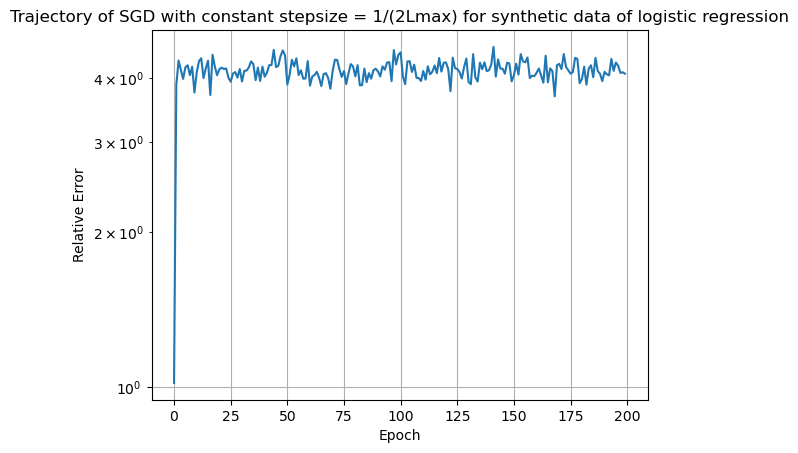

In [12]:
# 41.2s

# SGD with logistic regression (synthetic data)
err_logit_synth = SGD(x0=x0_logit_synth, xmin=xmin_logit_synth, 
                      grad=grad_logit_fi, A=A_logit_synth, b=b_logit_synth, 
                      lamb=lamb_logit_synth, step=gamma_logit_synth, 
                      n_iter=200*n_logit_synth, trials=10, progress=False)

plt.plot(np.arange(len(err_logit_synth[::n_logit_synth])), err_logit_synth[::n_logit_synth])
plt.yscale('log')
plt.grid(True)
plt.ylabel("Relative Error")
plt.xlabel("Epoch")
plt.title('Trajectory of SGD with constant stepsize = 1/(2Lmax) for synthetic data of logistic regression')

<span style="color:DodgerBlue"> 

It is abnormal for the relative error to increase and level off over the epochs. I suspect that it had to do with bad initialization with the zero vector, which could already be fairly close to the real solution, e.g., already within the neighborhood of convergence, or even closer to the real solution than the GD approximation. I thus repeated SGD with synthetic logistic data except with random standard normal initialization for $x_{min}$, as shown below. 

</span>

Text(0.5, 1.0, 'Trajectory of SGD with constant step size for synthetic data of logistic regression (random initialization)')

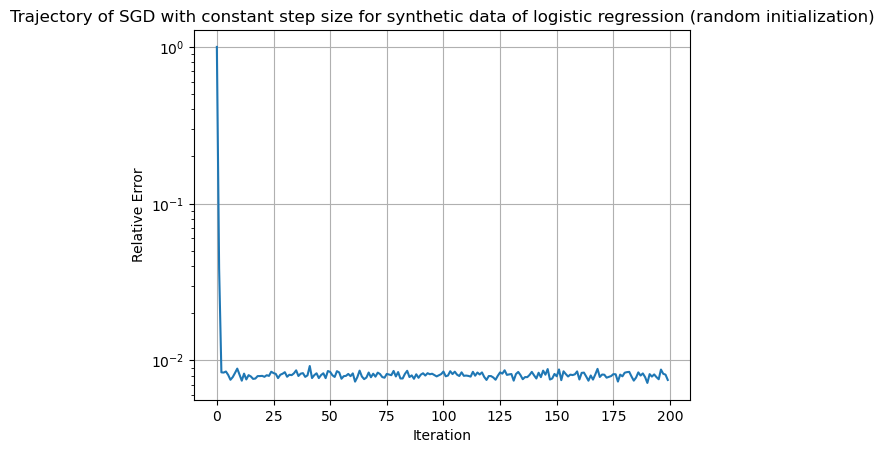

In [34]:
# 41.5s

# SGD with logistic regression (synthetic data), random initialization
err_logit_synth_rand_init = SGD(x0=x0_logit_synth_rand_init, xmin=xmin_logit_synth, 
                                grad=grad_logit_fi, A=A_logit_synth, b=b_logit_synth, 
                                lamb=lamb_logit_synth, step=gamma_logit_synth, 
                                n_iter=200*n_logit_synth, trials=10, progress=False)

plt.plot(np.arange(len(err_logit_synth_rand_init[::n_logit_synth])), err_logit_synth_rand_init[::n_logit_synth])
plt.yscale('log')
plt.grid(True)
plt.ylabel("Relative Error")
plt.xlabel("Iteration")
plt.title('Trajectory of SGD with constant step size for synthetic data of logistic regression (random initialization)')

<span style="color:DodgerBlue"> 

Overall, with good initialization, both plots (one for each type of regression problem) align with the theoretical results. The relative error decreases linearly and levels off at a value greater than 0, suggesting linear convergence to a neighborhood, matching Theorem 5 in Lectures 4-6. 

</span>

$\textbf{1.1.3}$ (12 points) Provide a plot for each problem (synthetic data sets) where you compare SGD with step-sizes $\gamma_1=10^{-3}$, $\gamma_2=10^{-5}$, $\gamma_3=10^{-7}$. Please explain your outputs. How the plot is related to the theoretical result?

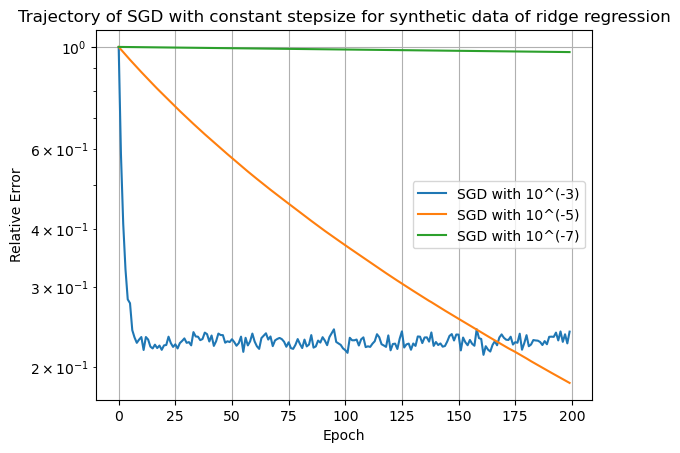

In [91]:
# 1m 2.1s

# SGD with ridge regression (synthetic data)
err_ridge_synth_g1 = SGD(x0=x0_ridge_synth, xmin=xmin_ridge_synth, 
                         grad=grad_ridge_fi, A=A_ridge_synth, b=b_ridge_synth, 
                         lamb=lamb_ridge_synth, step=1.0e-3, 
                         n_iter=200*n_ridge_synth, trials=10, progress=False)
err_ridge_synth_g2 = SGD(x0=x0_ridge_synth, xmin=xmin_ridge_synth, 
                         grad=grad_ridge_fi, A=A_ridge_synth, b=b_ridge_synth, 
                         lamb=lamb_ridge_synth, step=1.0e-5, 
                         n_iter=200*n_ridge_synth, trials=10, progress=False)
err_ridge_synth_g3 = SGD(x0=x0_ridge_synth, xmin=xmin_ridge_synth, 
                         grad=grad_ridge_fi, A=A_ridge_synth, b=b_ridge_synth, 
                         lamb=lamb_ridge_synth, step=1.0e-7, 
                         n_iter=200*n_ridge_synth, trials=10, progress=False)

# Plot the Relative Error
plt.plot(np.arange(len(err_ridge_synth_g1[::n_ridge_synth])), err_ridge_synth_g1[::n_ridge_synth], label = 'SGD with 10^(-3)')
plt.plot(np.arange(len(err_ridge_synth_g2[::n_ridge_synth])), err_ridge_synth_g2[::n_ridge_synth], label = 'SGD with 10^(-5)')
plt.plot(np.arange(len(err_ridge_synth_g3[::n_ridge_synth])), err_ridge_synth_g3[::n_ridge_synth], label = 'SGD with 10^(-7)')
plt.yscale('log')
plt.grid(True)
plt.ylabel("Relative Error")
plt.xlabel("Epoch")
plt.title('Trajectory of SGD with constant stepsize for synthetic data of ridge regression')
plt.legend()

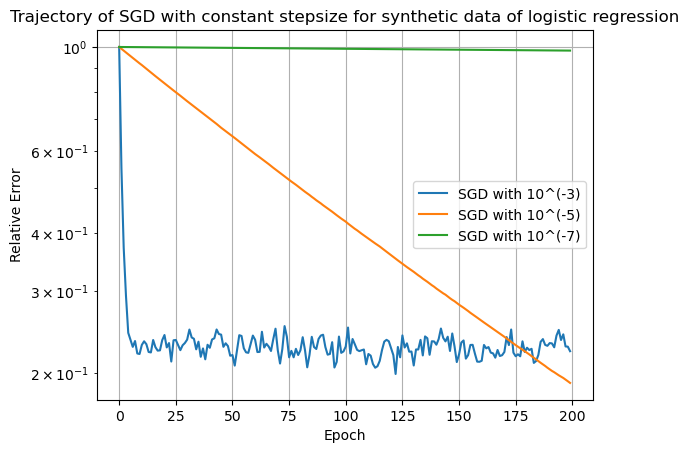

In [94]:
# 2m 4.5s

# SGD with logistic regression (synthetic data)
err_logit_synth_g1 = SGD(x0=x0_logit_synth, xmin=xmin_logit_synth, 
                         grad=grad_logit_fi, A=A_logit_synth, b=b_logit_synth, 
                         lamb=lamb_logit_synth, step=1.0e-3, 
                         n_iter=200*n_logit_synth, trials=10, progress=False)
err_logit_synth_g2 = SGD(x0=x0_logit_synth, xmin=xmin_logit_synth, 
                         grad=grad_logit_fi, A=A_logit_synth, b=b_logit_synth, 
                         lamb=lamb_logit_synth, step=1.0e-5, 
                         n_iter=200*n_logit_synth, trials=10, progress=False)
err_logit_synth_g3 = SGD(x0=x0_logit_synth, xmin=xmin_logit_synth, 
                         grad=grad_logit_fi, A=A_logit_synth, b=b_logit_synth, 
                         lamb=lamb_logit_synth, step=1.0e-7, 
                         n_iter=200*n_logit_synth, trials=10, progress=False)

# Plot the Relative Error
plt.plot(np.arange(len(err_logit_synth_g1[::n_logit_synth])), err_logit_synth_g1[::n_logit_synth], label = 'SGD with 10^(-3)')
plt.plot(np.arange(len(err_logit_synth_g2[::n_logit_synth])), err_logit_synth_g2[::n_logit_synth], label = 'SGD with 10^(-5)')
plt.plot(np.arange(len(err_logit_synth_g3[::n_logit_synth])), err_logit_synth_g3[::n_logit_synth], label = 'SGD with 10^(-7)')
plt.yscale('log')
plt.grid(True)
plt.ylabel("Relative Error")
plt.xlabel("Epoch")
plt.title('Trajectory of SGD with constant stepsize for synthetic data of logistic regression')
plt.legend()

<span style="color:DodgerBlue"> 

Both plots make sense theoretically from the three aspects below: 

1. Note that all step sizes used in this problem fall in the region $(0, \dfrac{1}{2\mathcal{L}}]$ ($\mathcal{L}$ computed in 1.1.1), and thus should enable SGD to linearly converge to a neighborhood, as suggested by the Theorem. Indeed, for both types of regression, the relative error decreases linearly on the plots. 

2. In addition, given the rate of convergence in the theorem $(1 - \gamma \mu)$, it suggests that with $\gamma \in (0, \dfrac{1}{2\mathcal{L}}]$, larger $\gamma$ leads to faster convergence. This is supported by the plots because before leveling off, the blue lines (largest $\gamma$) are the steepest, the orange lines (2nd largest $\gamma$) are a little flatter, and the green lines (smallest $\gamma$) are the flattest.  

3. Lastly, the size of the neighborhood $\dfrac{2 \gamma \sigma^2}{\mu}$ should decrease as $\gamma$ decreases. This is supported by the plots because the orange lines ($\gamma = 1e-5$) clearly reaches farther below than the blue lines ($\gamma = 1e-3$).  

</span>

$\textbf{1.2.}$ (10 points) Provide a comparison (generate plots) of "Constant Vs decreasing/switching step-size rule" (choices that were proposed in class) for SGD for solving ridge regression and $\ell_2$-logistic regression problem. What is the main output? Does the methods behave as expected? Here we need to generate two plots for each problem (one plot on synthetic data and one on the real data we explain above).

Recall that the switching step-size rule for strongly convex and smooth problems are: 

\begin{equation}
\gamma_k= 
\begin{cases}
\displaystyle \dfrac{1}{2 \cal L} & \text{for}\quad k \leq 4\lceil\mathcal{K} \rceil \\[0.3cm]
\displaystyle \dfrac{2k+1}{(k+1)^2 \mu} &  \text{for}\quad k > 4\lceil\mathcal{K} \rceil,
\end{cases}
\end{equation}
where $\mathcal{K} = \cal L /\mu $ .

Switch at the 13964.0th iteration,  i.e., the 13.964th epoch.


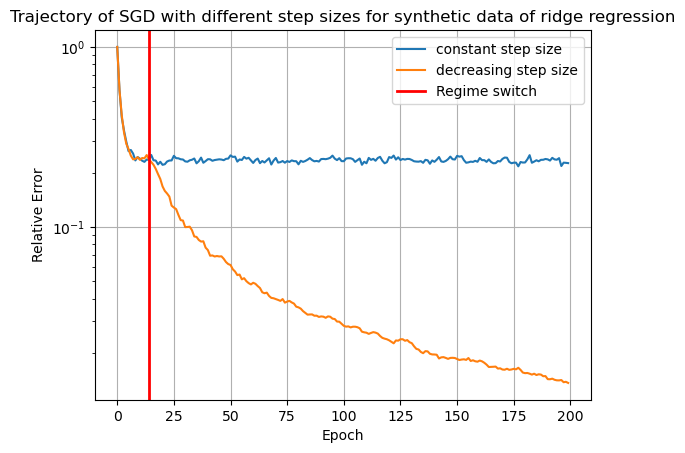

In [25]:
# 43s

# SGD with ridge regression (synthetic data)
k_switch_ridge_synth = get_switch_iteration(Lcal_ridge_synth, mu_ridge_synth)
print(f"Switch at the {k_switch_ridge_synth}th iteration,  i.e., the {k_switch_ridge_synth/n_ridge_synth}th epoch.")
err_ridge_synth_noswitch = SGD(x0=x0_ridge_synth, xmin=xmin_ridge_synth, 
                               grad=grad_ridge_fi, A=A_ridge_synth, b=b_ridge_synth, 
                               lamb=lamb_ridge_synth, 
                               step=gamma_ridge_synth, 
                               n_iter=n_ridge_synth * 200, trials=10, progress=False)
err_ridge_synth_switch = SGD(x0=x0_ridge_synth, xmin=xmin_ridge_synth, 
                             grad=grad_ridge_fi, A=A_ridge_synth, b=b_ridge_synth, 
                             lamb=lamb_ridge_synth, switch=True, 
                             L_cal=Lcal_ridge_synth, mu=mu_ridge_synth, 
                             n_iter=n_ridge_synth * 200, trials=10, progress=False)

# Plot the Relative Error
plt.plot(np.arange(len(err_ridge_synth_noswitch[::n_ridge_synth])), 
         err_ridge_synth_noswitch[::n_ridge_synth], 
         label = "constant step size")
plt.plot(np.arange(len(err_ridge_synth_switch[::n_ridge_synth])), 
         err_ridge_synth_switch[::n_ridge_synth], 
         label = "decreasing step size")
plt.axvline(k_switch_ridge_synth / n_ridge_synth, color='r', linewidth=2, label="Regime switch")
plt.yscale('log')
plt.grid(True)
plt.ylabel("Relative Error")
plt.xlabel("Epoch")
plt.title('Trajectory of SGD with different step sizes for synthetic data of ridge regression')
plt.legend()

In [14]:
# 10.3s

# Estimating xmin using GD (ridge regression, real data)
x0_ridge_real = np.zeros(d_ridge_real)
xmin_ridge_real = GD(x0=x0_ridge_real, A=A_ridge_real, b=b_ridge_real, lamb=lamb_ridge_real, 
                      step=gamma_ridge_real, grad=grad_ridge_f, n_iter=200000, progress=True)

100%|██████████| 200000/200000 [00:10<00:00, 19424.68it/s]


Switch at the 157456.0th iteration,  i.e., the 37.69595403399569th epoch.


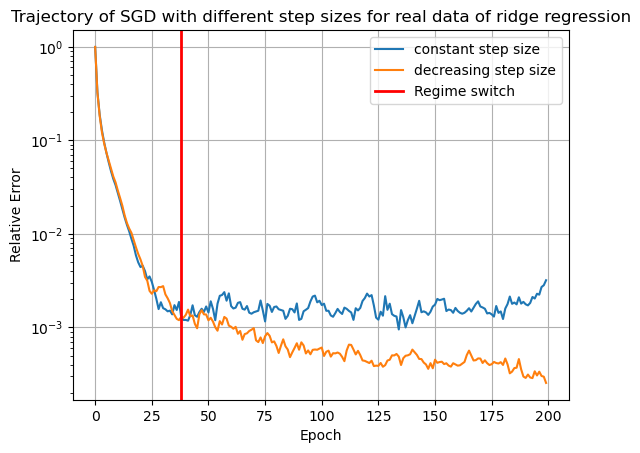

In [15]:
# 2m 37.9s

# SGD with ridge regression (real data)
k_switch_ridge_real = get_switch_iteration(Lcal_ridge_real, mu_ridge_real)
print(f"Switch at the {k_switch_ridge_real}th iteration,  i.e., the {k_switch_ridge_real/n_ridge_real}th epoch.")

err_ridge_real_noswitch = SGD(x0=x0_ridge_real, xmin=xmin_ridge_real, 
                              grad=grad_ridge_fi, A=A_ridge_real, b=b_ridge_real, 
                              lamb=lamb_ridge_real, 
                              step=gamma_ridge_real, 
                              n_iter=n_ridge_real * 200, trials=10, progress=False)
err_ridge_real_switch = SGD(x0=x0_ridge_real, xmin=xmin_ridge_real, 
                            grad=grad_ridge_fi, A=A_ridge_real, b=b_ridge_real, 
                            lamb=lamb_ridge_real, switch=True, 
                            L_cal=Lcal_ridge_real, mu=mu_ridge_real, 
                            n_iter=n_ridge_real * 200, trials=10, progress=False)

# Plot the Relative Error
plt.plot(np.arange(len(err_ridge_real_noswitch[::n_ridge_real])), 
         err_ridge_real_noswitch[::n_ridge_real], 
         label = "constant step size")
plt.plot(np.arange(len(err_ridge_real_switch[::n_ridge_real])), 
         err_ridge_real_switch[::n_ridge_real], 
         label = "decreasing step size")
plt.axvline(k_switch_ridge_real / n_ridge_real, color='r', linewidth=2, label="Regime switch")
plt.yscale('log')
plt.grid(True)
plt.ylabel("Relative Error")
plt.xlabel("Epoch")
plt.title('Trajectory of SGD with different step sizes for real data of ridge regression')
plt.legend()

The switch happens at the 301804.0th iteration, i.e., the 150.902th epoch.


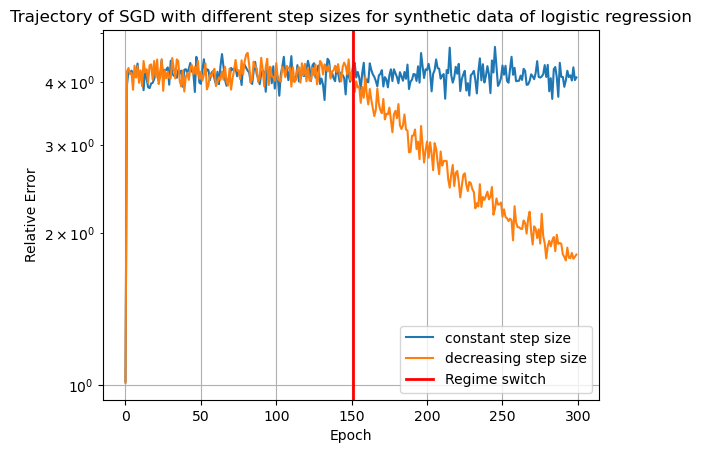

In [16]:
# 2m 3.2s

# SGD with logistic regression (synthetic data)
k_switch_logit_synth = get_switch_iteration(Lcal_logit_synth, mu_logit_synth)
print(f"The switch happens at the {k_switch_logit_synth}th iteration, i.e., the {k_switch_logit_synth/n_logit_synth}th epoch.")

err_logit_synth_noswitch = SGD(x0=x0_logit_synth, xmin=xmin_logit_synth, 
                               grad=grad_logit_fi, A=A_logit_synth, b=b_logit_synth, 
                               lamb=lamb_logit_synth, 
                               step=gamma_logit_synth, 
                               n_iter=n_logit_synth * 300, trials=10, progress=False)
err_logit_synth_switch = SGD(x0=x0_logit_synth, xmin=xmin_logit_synth, 
                             grad=grad_logit_fi, A=A_logit_synth, b=b_logit_synth, 
                             lamb=lamb_logit_synth, switch=True, 
                             L_cal=Lcal_logit_synth, mu=mu_logit_synth, 
                             n_iter=n_logit_synth * 300, trials=10, progress=False)

# Plot the Relative Error
plt.plot(np.arange(len(err_logit_synth_noswitch[::n_logit_synth])), 
         err_logit_synth_noswitch[::n_logit_synth], 
         label = "constant step size")
plt.plot(np.arange(len(err_logit_synth_switch[::n_logit_synth])), 
         err_logit_synth_switch[::n_logit_synth], 
         label = "decreasing step size")
plt.axvline(k_switch_logit_synth / n_logit_synth, color='r', linewidth=2, label="Regime switch")
plt.yscale('log')
plt.grid(True)
plt.ylabel("Relative Error")
plt.xlabel("Epoch")
plt.title('Trajectory of SGD with different step sizes for synthetic data of logistic regression')
plt.legend()

The switch happens at the 301804.0th iteration, i.e., the 150.902th epoch.


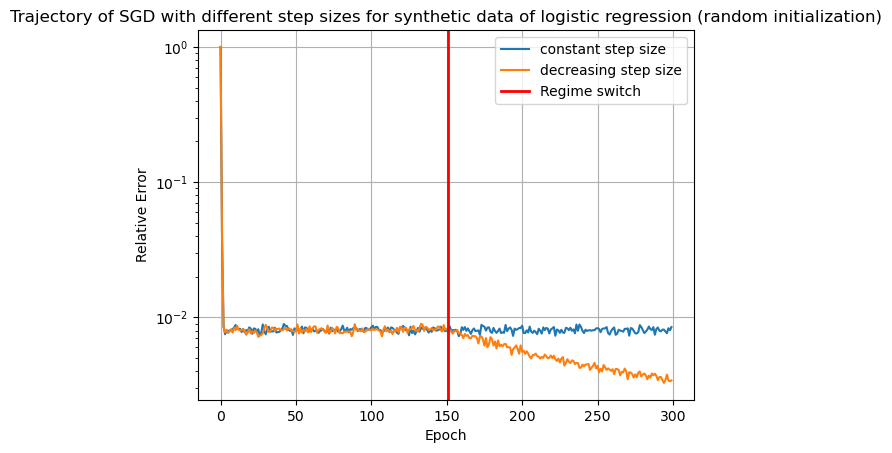

In [35]:
# 2m 3.4s

# SGD with logistic regression (synthetic data, random initialization)
k_switch_logit_synth_rand_init = get_switch_iteration(Lcal_logit_synth, mu_logit_synth)
print(f"The switch happens at the {k_switch_logit_synth_rand_init}th iteration, i.e., the {k_switch_logit_synth_rand_init/n_logit_synth}th epoch.")

err_logit_synth_rand_init_noswitch = SGD(x0=x0_logit_synth_rand_init, xmin=xmin_logit_synth, 
                                         grad=grad_logit_fi, A=A_logit_synth, b=b_logit_synth, 
                                         lamb=lamb_logit_synth, 
                                         step=gamma_logit_synth, 
                                         n_iter=n_logit_synth * 300, trials=10, progress=False)
err_logit_synth_rand_init_switch = SGD(x0=x0_logit_synth_rand_init, xmin=xmin_logit_synth, 
                                       grad=grad_logit_fi, A=A_logit_synth, b=b_logit_synth, 
                                       lamb=lamb_logit_synth, switch=True, 
                                       L_cal=Lcal_logit_synth, mu=mu_logit_synth, 
                                       n_iter=n_logit_synth * 300, trials=10, progress=False)

# Plot the Relative Error
plt.plot(np.arange(len(err_logit_synth_rand_init_noswitch[::n_logit_synth])), 
         err_logit_synth_rand_init_noswitch[::n_logit_synth], 
         label = "constant step size")
plt.plot(np.arange(len(err_logit_synth_rand_init_switch[::n_logit_synth])), 
         err_logit_synth_rand_init_switch[::n_logit_synth], 
         label = "decreasing step size")
plt.axvline(k_switch_logit_synth_rand_init / n_logit_synth, color='r', linewidth=2, label="Regime switch")
plt.yscale('log')
plt.grid(True)
plt.ylabel("Relative Error")
plt.xlabel("Epoch")
plt.title('Trajectory of SGD with different step sizes for synthetic data of logistic regression (random initialization)')
plt.legend()

In [18]:
# 1m 18.2s

# Estimating xmin using GD (logistic regression, real data)
x0_logit_real = np.zeros(d_logit_real)
xmin_logit_real = GD(x0=x0_logit_real, A=A_logit_real, b=b_logit_real, lamb=lamb_logit_real, 
                      step=gamma_logit_real, grad=grad_logit_f, n_iter=200000, progress=True)

100%|██████████| 200000/200000 [01:18<00:00, 2556.46it/s]


The switch happens at the 22476.0th iteration, i.e., the 14.003738317757009th epoch.


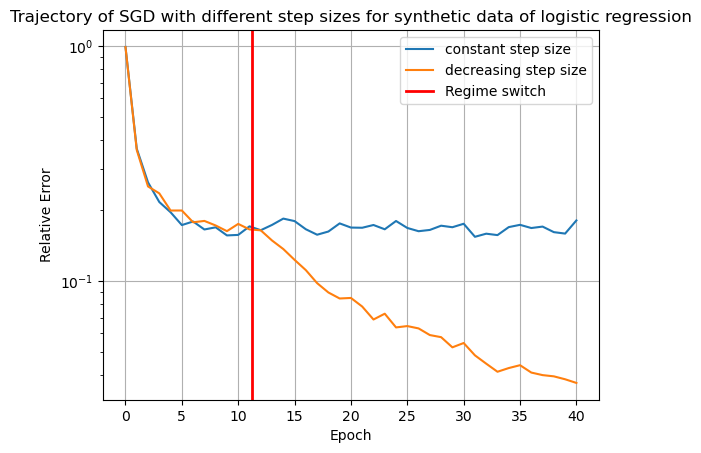

In [19]:
# 17.2s

# SGD with logistic regression (real data)
k_switch_logit_real = get_switch_iteration(Lcal_logit_real, mu_logit_real)
print(f"The switch happens at the {k_switch_logit_real}th iteration, i.e., the {k_switch_logit_real/n_logit_real}th epoch.")

err_logit_real_noswitch = SGD(x0=x0_logit_real, xmin=xmin_logit_real, 
                               grad=grad_logit_fi, A=A_logit_real, b=b_logit_real, 
                               lamb=lamb_logit_real, 
                               step=gamma_logit_real, 
                               n_iter=n_logit_real * 50, trials=10, progress=False)
err_logit_real_switch = SGD(x0=x0_logit_real, xmin=xmin_logit_real, 
                             grad=grad_logit_fi, A=A_logit_real, b=b_logit_real, 
                             lamb=lamb_logit_real, switch=True, 
                             L_cal=Lcal_logit_real, mu=mu_logit_real, 
                             n_iter=n_logit_real * 50, trials=10, progress=False)

# Plot the Relative Error
plt.plot(np.arange(len(err_logit_real_noswitch[::n_logit_synth])), 
         err_logit_real_noswitch[::n_logit_synth], 
         label = "constant step size")
plt.plot(np.arange(len(err_logit_real_switch[::n_logit_synth])), 
         err_logit_real_switch[::n_logit_synth], 
         label = "decreasing step size")
plt.axvline(k_switch_logit_real / n_logit_synth, color='r', linewidth=2, label="Regime switch")
plt.yscale('log')
plt.grid(True)
plt.ylabel("Relative Error")
plt.xlabel("Epoch")
plt.title('Trajectory of SGD with different step sizes for synthetic data of logistic regression')
plt.legend()

<span style="color:DodgerBlue"> 

Yes, the plots support the theoretical results pertaining to regime switching in terms of the two aspects below:

1. Before the regime switch, both lines represent the same step size $= \dfrac{1}{2 \mathcal{L}}$ and almost completely overlap with each other. The relative error decreases linearly, as suggested by Theorem 5. 
2. After the regime switch, the orange line represents decreasing step size over iterations. It shows sublinear convergence (flatter after the switch than before) and reaches lower than the blue line, suggesting convergence to a smaller neighborhood than SGD without regime switch. These behaviors match the predictions made by Theorem 6 from Lectures 4-6. 

</span>

$\textbf{1.3.}$  (10 points) Provide a Comparison (generate plots) of "Uniform sampling Vs Importance Sampling (single-element regime)" for SGD for solving the two problems under study. What is the output? Please explain your findings. For this task focus only on synthetic datasets (that is generate 1 plot for each problem). 

<span style="color:DodgerBlue"> 

For importance sampling, I used partially biased sampling: $\forall i \in [n], p_i = \dfrac{1}{2} \dfrac{L_i}{\sum_{j \in [n]} L_j} + \dfrac{1}{2n}$.

</span>

In [26]:
# 0.0s

# Compute pi's 
def get_pi_vec(A, lamb, get_Li):
    """Compute pi vector for importance sampling."""
    n = A.shape[0]
    Li_vec = get_Li(A, lamb)
    pi_L_vec = Li_vec / Li_vec.sum()
    return 0.5 * pi_L_vec + 0.5 / n

<span style="color:DodgerBlue"> 

Note that we longer have $\mathcal{L} = L_{max}$ because $\mathcal{L} = \dfrac{1}{n} \max_{i \in [n]} \dfrac{L_i}{p_i}$. Under uniform sampling, $\mathcal{L} = L_{max}$ because $\forall i, p_i = \dfrac{1}{n}$. Under importance sampling, I need to recompute $\mathcal{L}$ with the new $p_i$'s, then the step sizes with $\dfrac{1}{2\mathcal{L}}$. 

</span>

In [21]:
# 0.0s

# Compute new step sizes under importance sampling (synthetic data)

pi_vec_ridge_synth_imp = get_pi_vec(A_ridge_synth, lamb_ridge_synth, get_Li_ridge)
Lcal_logit_synth_imp = (get_Li_ridge(A_ridge_synth, lamb_ridge_synth) / pi_vec_ridge_synth_imp).max() / n_ridge_synth
gamma_ridge_synth_imp = 0.5 / Lcal_logit_synth_imp

pi_vec_logit_synth_imp = get_pi_vec(A_logit_synth, lamb_logit_synth, get_Li_logit)
Lcal_logit_synth_imp = (get_Li_logit(A_logit_synth, lamb_logit_synth) / pi_vec_logit_synth_imp).max() / n_logit_synth
gamma_logit_synth_imp = 0.5 / Lcal_logit_synth_imp

print(f"Under importance sampling, the step size is {gamma_ridge_synth_imp} for ridge regression, {gamma_logit_synth_imp} for logistic regression.")

Under importance sampling, the step size is 0.0011367797361672258 for ridge regression, 0.01659341485581649 for logistic regression.


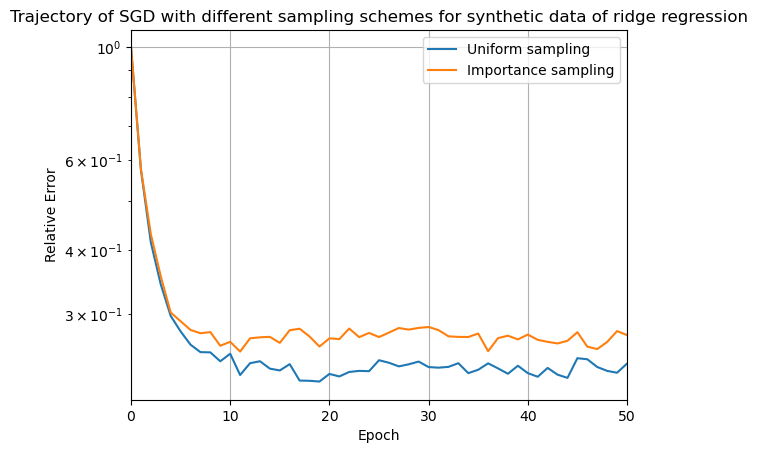

In [22]:
# 41.4s

# SGD with ridge regression (synthetic data)
err_ridge_synth_imp = SGD(x0=x0_ridge_synth, xmin=xmin_ridge_synth, 
                          grad=grad_ridge_fi, A=A_ridge_synth, b=b_ridge_synth, 
                          lamb=lamb_ridge_synth, step=gamma_ridge_synth_imp, 
                          pi_importance_vec=pi_vec_ridge_synth_imp, 
                          n_iter=200*n_ridge_synth, trials=10, progress=False)

# Plot the Relative Error
plt.plot(np.arange(len(err_ridge_synth[::n_ridge_synth])), err_ridge_synth[::n_ridge_synth], label="Uniform sampling")
plt.plot(np.arange(len(err_ridge_synth_imp[::n_ridge_synth])), err_ridge_synth_imp[::n_ridge_synth], label="Importance sampling")
plt.xlim([0, 50])
plt.yscale('log')
plt.grid(True)
plt.ylabel("Relative Error")
plt.xlabel("Epoch")
plt.title('Trajectory of SGD with different sampling schemes for synthetic data of ridge regression')
plt.legend()

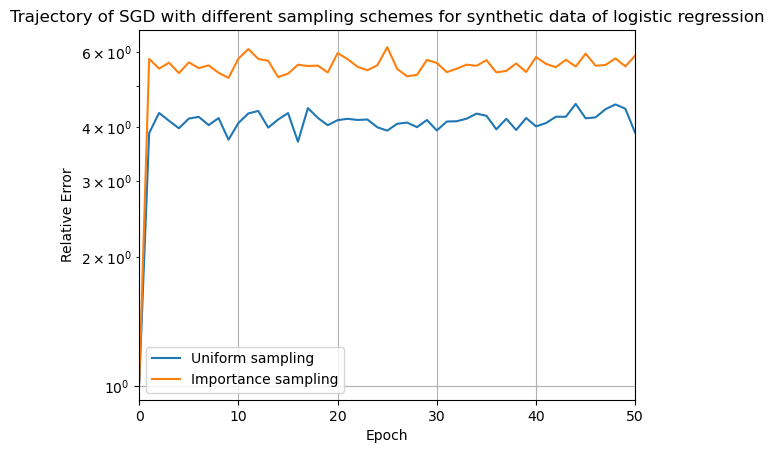

In [23]:
# 1m 51.5s

# SGD with logistic regression (synthetic data)
err_logit_synth_imp = SGD(x0=x0_logit_synth, xmin=xmin_logit_synth, 
                          grad=grad_logit_fi, A=A_logit_synth, b=b_logit_synth, 
                          lamb=lamb_logit_synth, step=gamma_logit_synth_imp, 
                          pi_importance_vec=pi_vec_logit_synth_imp, 
                          n_iter=200*n_logit_synth, trials=10, progress=False)

# Plot the Relative Error
plt.plot(np.arange(len(err_logit_synth[::n_logit_synth])), err_logit_synth[::n_logit_synth], label="Uniform sampling")
plt.plot(np.arange(len(err_logit_synth_imp[::n_logit_synth])), err_logit_synth_imp[::n_logit_synth], label="Importance sampling")
plt.xlim([0, 50])
plt.yscale('log')
plt.grid(True)
plt.ylabel("Relative Error")
plt.xlabel("Epoch")
plt.title('Trajectory of SGD with different sampling schemes for synthetic data of logistic regression')
plt.legend()

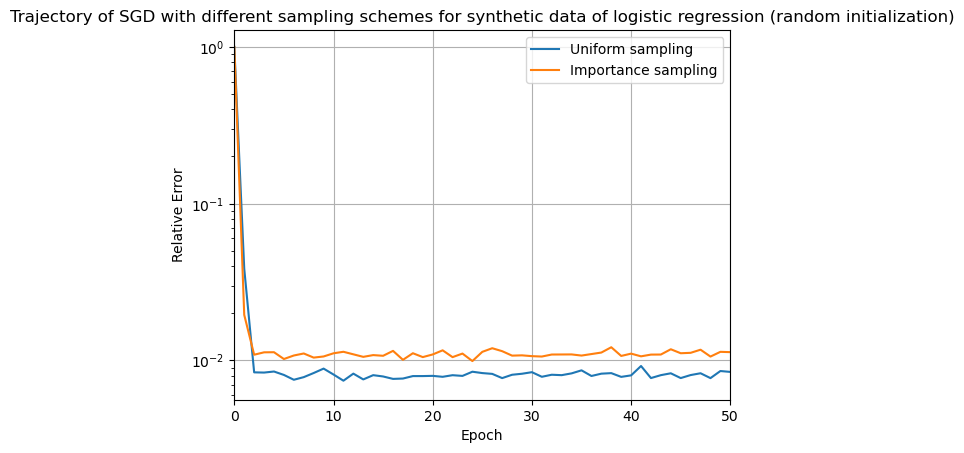

In [36]:
# 1m 51.4s

# SGD with logistic regression (synthetic data, random initialization)
err_logit_synth_rand_init_imp = SGD(x0=x0_logit_synth_rand_init, xmin=xmin_logit_synth, 
                                    grad=grad_logit_fi, A=A_logit_synth, b=b_logit_synth, 
                                    lamb=lamb_logit_synth, step=gamma_logit_synth_imp, 
                                    pi_importance_vec=pi_vec_logit_synth_imp, 
                                    n_iter=200*n_logit_synth, trials=10, progress=False)

# Plot the Relative Error
plt.plot(np.arange(len(err_logit_synth_rand_init[::n_logit_synth])), 
         err_logit_synth_rand_init[::n_logit_synth], 
         label="Uniform sampling")
plt.plot(np.arange(len(err_logit_synth_rand_init_imp[::n_logit_synth])), 
         err_logit_synth_rand_init_imp[::n_logit_synth], 
         label="Importance sampling")
plt.xlim([0, 50])
plt.yscale('log')
plt.grid(True)
plt.ylabel("Relative Error")
plt.xlabel("Epoch")
plt.title('Trajectory of SGD with different sampling schemes for synthetic data of logistic regression (random initialization)')
plt.legend()

<span style="color:DodgerBlue"> 

The results generally support Theorem 5 (for vanilla SGD) and do not contradict the theories pertaining to sampling scheme comparisons. 

Note that the step sizes for SGD with importance sampling are larger than their counterparts with uniform sampling. Theorem 5 suggests that a larger step size entails slower convergence and larger neighborhood. While the convergence rate is not obviously discernable in the plots, we can see that the orange lines (importance sampling) are clearly above the blue lines (uniform sampling), suggesting a larger neighborhood resulting from the larger step sizes, as predicted by theory. 


In class, we discussed that depending on the relationship between $L_{max}$ and $\bar{L}$, the iteration complexity of SGD with importance sampling varies in comparison to vanilla SGD. Importance sampling can have iteration complexity $n/2$ smaller or two times larger in the extreme cases. Importance sampling is not too different from vanilla SGD when $L_{max} \approx \bar{L}$, which could be the case here, as shown below:

</span>

In [40]:
Lmax_ridge_synth = get_Li_ridge(A_ridge_synth, lamb_ridge_synth).max()
Lbar_ridge_synth = get_Li_ridge(A_ridge_synth, lamb_ridge_synth).mean()
Lmax_logit_synth = get_Li_ridge(A_logit_synth, lamb_logit_synth).max()
Lbar_logit_synth = get_Li_ridge(A_logit_synth, lamb_logit_synth).mean()

print(f"For ridge regression, Lmax = {Lmax_ridge_synth}, Lbar = {Lbar_ridge_synth}.")
print(f"For logistic regression, Lmax = {Lmax_logit_synth}, Lbar = {Lbar_logit_synth}.")

For ridge regression, Lmax = 488.1098121992658, Lbar = 400.2562232430856.
For logistic regression, Lmax = 150.8995157644197, Lbar = 100.33408008907652.


### Task 2: On variance-reduced methods: Fast convergence to the exact solution ### 

In the class we present and analyze two variance reduced methods for solving problems similar to ridge regression and logistic regression. These are the L-SVRG and SAGA. In this task we will evaluate the behaviour of these methods.

For all plots in this task, to evaluate SGD and the variance reduced methods, we use the relative error measure  $\frac{\|x^k - x^* \|^2}{\|x^0 - x^* \|^2}$ and plot its value as the algorithms progress. For all implementations, select the starting point $x^0$ to be the vector of all zeros. Please run each method until a pre-specified maximum number of epochs that you will select in order for the theoretical result to be illustrated. In this task since variance reduced methods require a full gradient evaluation in some of the iteration for the horizontal axis you should use the number of epochs (number of stochastic gradient evaluations) for a fair comparison to the vanilla SGD.

$\textbf{3.1.}$ (20 points) As a first sub-task, please design L-SVRG and SAGA method as presented in the class. 


In [27]:
### Include your solution to TASK 3 at this point (before Task 4)

# L-SVRG

def L_SVRG(x0, xmin, grad_i, grad_full, A, b, lamb, step, p, n_iter=500, trials=10, progress=False):
    import tqdm
    relative_error_vec = np.zeros(n_iter) # Placeholder for relative errors
    n= A.shape[0] # Number of samples

    for _ in range(trials): # Iterate over the trial
        x = x0; w = x0
        relative_error_vec_t = np.zeros(n_iter)
        full_grad = grad_full(A, b, w, lamb)

        for it in tqdm.tqdm(range(n_iter), disable=not progress): # Iterate through the iterations/epochs
            # Sample a single element (uniform)
            i = np.random.choice(n)
            # Update xk
            x = x - step * (grad_i(A[i,], b[i], x, lamb) - grad_i(A[i,], b[i], w, lamb) + full_grad)
            # Update wk with probability p
            update_wk = np.random.choice([True, False], p=[p, 1-p])
            if update_wk:
                w = x
                full_grad = grad_full(A, b, w, lamb)

            # Compute relative error and store it 
            relative_error = np.square(np.linalg.norm(x-xmin) / np.linalg.norm(x0-xmin))
            relative_error_vec_t[it] = relative_error

        relative_error_vec += relative_error_vec_t 

    return relative_error_vec / trials # Return average relative error over the runs

In [28]:
# SAGA

def SAGA(x0, xmin, grad, A, b, lamb, step, n_iter=500, trials=10, progress=False):
    import tqdm
    relative_error_vec = np.zeros(n_iter) # Placeholder for relative errors
    n, d = A.shape # Number of samples

    for _ in range(trials): # Iterate over the trial
        x = x0
        relative_error_vec_t = np.zeros(n_iter)

        grad_table = np.zeros((n, d)) # To store gradient of fi evaluated at phi^k_i
        avg_grad = np.zeros(d) # To keep track of avg gradient of all fi evaluated at phi^k_i

        for it in tqdm.tqdm(range(n_iter), disable=not progress): # Iterate through the iterations/epochs
            # Sample a single element (uniform)
            i = np.random.choice(n)
            # Compute gradient of fi evaluated at xk (equiv., phi_j^{k+1})
            curr_grad = grad(A[i,], b[i], x, lamb) 
            # Update xk
            x = x - step * (curr_grad - grad_table[i] + avg_grad)
            # Update avg gradient
            avg_grad += (curr_grad - grad_table[i]) / n
            # Update the gradient table
            grad_table[i] = curr_grad
            
            # Compute relative error and store it 
            relative_error = np.square(np.linalg.norm(x-xmin) / np.linalg.norm(x0-xmin))
            relative_error_vec_t[it] = relative_error

        relative_error_vec += relative_error_vec_t 

    return relative_error_vec / trials # Return average relative error over the runs

$\textbf{3.2.}$ (30 points) Using the synthetic datasets described in Task 1, compare in a plot, the L-SVRG, the SAGA and the constant step-size SGD (all under uniform single-element sampling) for solving ridge regression and logistic regression problems. For each method use the parameters suggested by the Theorems presented in the class. For this subtask you will need to produce 2 plots (one for each problem). 
Explain your findings. Do the methods behave as the theorems predict?

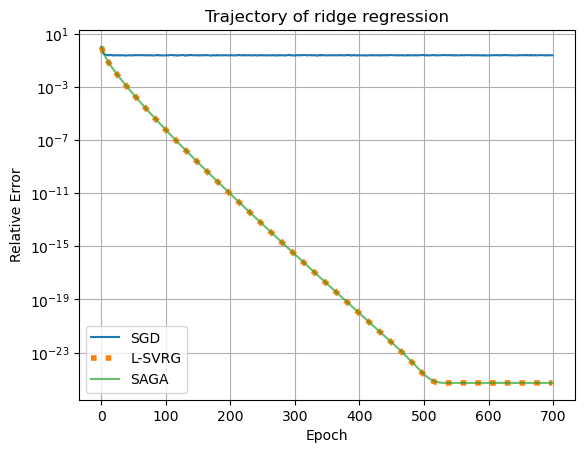

In [29]:
# 5m 8.9s

# Ridge regression (synthetic data)
SGD_ridge_err = SGD(x0=x0_ridge_synth, xmin=xmin_ridge_synth, 
                    grad=grad_ridge_fi, A=A_ridge_synth, b=b_ridge_synth, 
                    lamb=lamb_ridge_synth, step=gamma_ridge_synth,
                    n_iter=700*n_ridge_synth, trials=10, progress=False) 
LSVRG_ridge_err = L_SVRG(x0=x0_ridge_synth, xmin=xmin_ridge_synth, 
                    grad_i=grad_ridge_fi, grad_full=grad_ridge_f, 
                    A=A_ridge_synth, b=b_ridge_synth, 
                    lamb=lamb_ridge_synth, step=1.0 / 6.0 / Lcal_ridge_synth,
                    p=1.0/n_ridge_synth, n_iter=700*n_ridge_synth, trials=10, progress=False) 
SAGA_ridge_err = SAGA(x0=x0_ridge_synth, xmin=xmin_ridge_synth, 
                    grad=grad_ridge_fi, A=A_ridge_synth, b=b_ridge_synth, 
                    lamb=lamb_ridge_synth, step=1.0 / 6.0 / Lcal_ridge_synth,
                    n_iter=700*n_ridge_synth, trials=10, progress=False) 

# Plot the Relative Error
plt.plot(np.arange(len(SGD_ridge_err[::n_ridge_synth])), SGD_ridge_err[::n_ridge_synth], label = 'SGD')
plt.plot(np.arange(len(LSVRG_ridge_err[::n_ridge_synth])), LSVRG_ridge_err[::n_ridge_synth], label = 'L-SVRG', linestyle=':', linewidth=4)
plt.plot(np.arange(len(SAGA_ridge_err[::n_ridge_synth])), SAGA_ridge_err[::n_ridge_synth], label = 'SAGA', alpha=0.7)


plt.yscale('log')
plt.grid(True)
plt.ylabel("Relative Error")
plt.xlabel("Epoch")
plt.title('Trajectory of ridge regression')
plt.legend()

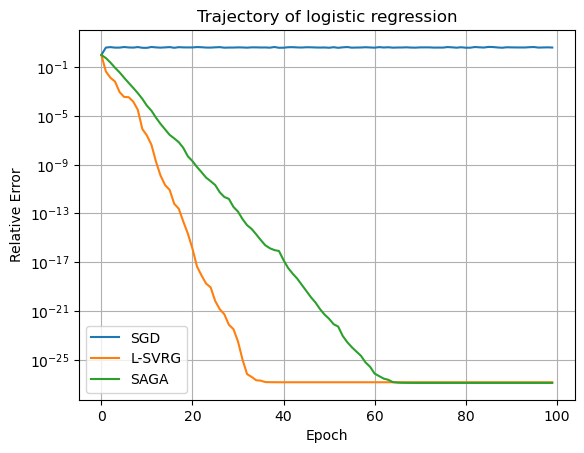

In [30]:
# 1m 26.6s

# Logistic regression (synthetic data)

SGD_logit_err = SGD(x0=x0_logit_synth, xmin=xmin_logit_synth, 
                    grad=grad_logit_fi, A=A_logit_synth, b=b_logit_synth, 
                    lamb=lamb_logit_synth, step=gamma_logit_synth,
                    n_iter=100*n_logit_synth, trials=10, progress=False) 
LSVRG_logit_err = L_SVRG(x0=x0_logit_synth, xmin=xmin_logit_synth, 
                         grad_i=grad_logit_fi, grad_full=grad_logit_f, 
                         A=A_logit_synth, b=b_logit_synth, 
                         lamb=lamb_logit_synth, step=1.0 / 6.0 / Lcal_logit_synth,
                         p=1.0/n_logit_synth, n_iter=100*n_logit_synth, trials=10, progress=False) 
SAGA_logit_err = SAGA(x0=x0_logit_synth, xmin=xmin_logit_synth, 
                      grad=grad_logit_fi, A=A_logit_synth, b=b_logit_synth, 
                      lamb=lamb_logit_synth, step=1.0 / 6.0 / Lcal_logit_synth,
                      n_iter=100*n_logit_synth, trials=10, progress=False) 

# Plot the Relative Error
plt.plot(np.arange(len(SGD_logit_err[::n_logit_synth])), SGD_logit_err[::n_logit_synth], label = 'SGD')
plt.plot(np.arange(len(LSVRG_logit_err[::n_logit_synth])), LSVRG_logit_err[::n_logit_synth], label = 'L-SVRG')
plt.plot(np.arange(len(SAGA_logit_err[::n_logit_synth])), SAGA_logit_err[::n_logit_synth], label = 'SAGA')


plt.yscale('log')
plt.grid(True)
plt.ylabel("Relative Error")
plt.xlabel("Epoch")
plt.title('Trajectory of logistic regression')
plt.legend()

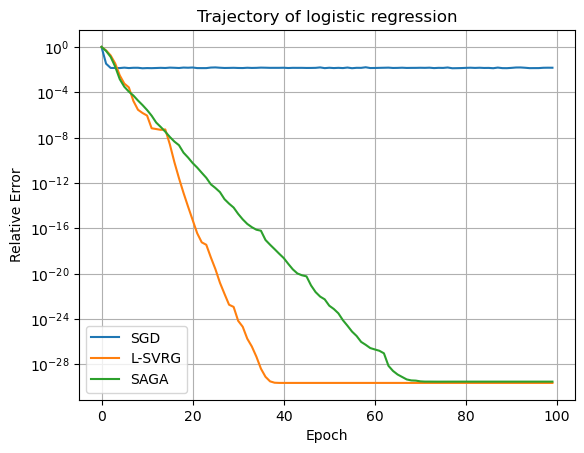

In [31]:
# 1m 27.1s

# Logistic regression (synthetic data, random initialization)
SGD_logit_err_rand_init = SGD(x0=x0_logit_synth_rand_init, xmin=xmin_logit_synth, 
                              grad=grad_logit_fi, A=A_logit_synth, b=b_logit_synth, 
                              lamb=lamb_logit_synth, step=gamma_logit_synth,
                              n_iter=100*n_logit_synth, trials=10, progress=False) 
LSVRG_logit_err_rand_init = L_SVRG(x0=x0_logit_synth_rand_init, xmin=xmin_logit_synth, 
                                   grad_i=grad_logit_fi, grad_full=grad_logit_f, 
                                   A=A_logit_synth, b=b_logit_synth, 
                                   lamb=lamb_logit_synth, step=1.0 / 6.0 / Lcal_logit_synth,
                                   p=1.0/n_logit_synth, n_iter=100*n_logit_synth, trials=10, progress=False) 
SAGA_logit_err_rand_init = SAGA(x0=x0_logit_synth_rand_init, xmin=xmin_logit_synth, 
                                grad=grad_logit_fi, A=A_logit_synth, b=b_logit_synth, 
                                lamb=lamb_logit_synth, step=1.0 / 6.0 / Lcal_logit_synth,
                                n_iter=100*n_logit_synth, trials=10, progress=False) 

# Plot the Relative Error
plt.plot(np.arange(len(SGD_logit_err_rand_init[::n_logit_synth])), SGD_logit_err_rand_init[::n_logit_synth], label = 'SGD')
plt.plot(np.arange(len(LSVRG_logit_err_rand_init[::n_logit_synth])), LSVRG_logit_err_rand_init[::n_logit_synth], label = 'L-SVRG')
plt.plot(np.arange(len(SAGA_logit_err_rand_init[::n_logit_synth])), SAGA_logit_err_rand_init[::n_logit_synth], label = 'SAGA')


plt.yscale('log')
plt.grid(True)
plt.ylabel("Relative Error")
plt.xlabel("Epoch")
plt.title('Trajectory of logistic regression')
plt.legend()

<span style="color:DodgerBlue"> 

The results overall make sense and match the theoretical predictions. Note that the relative error $< 10e-25$ essentially entails convergence with no neighborhood (i.e., a really small number representable by a computer). The plots above show that while vanilla SGD converges linearly to a neighborhood, both variance-reduction methods converge to the exact solution with no neighborhood, as described in the theories.

However, it is unclear to me why both variance-reduction methods converge at approximately the same rate for ridge regression, but L-SVRG was faster than SAGA for logistic regression. In Lectures 9-10, we showed that with $\gamma = \dfrac{1}{6L}$, for both variance-reduction methods, the rate of convergence is upper bounded by $(1-\min \{\dfrac{\mu}{6L}, \dfrac{1}{2n}\})$ (with $p= \dfrac{1}{2n}$ for L-SVRG). For both algorithms, I used $\gamma = \dfrac{1}{6L_{max}}$ because I already computed the $L_{max}$ values and that $L_{max}$ is an upper bound for $L$. While my results don't contradict with the theoretical bounds, I don't have a good explanation for their difference in practice. 

</span>